## Why the Digital Option Example Exposes MLMC’s Blind-Sampling Failure

1. **Payoff Discontinuity → Poor Coupling**  
   A digital payoff  
   $$P(S_T) = \mathbf{1}_{\{S_T > K\}}$$  
   jumps from 0 to 1 at $S_T = K$. MLMC relies on strong coupling between “fine” and “coarse” paths so that  
   $$Y_\ell = P_\ell - P_{\ell-1}$$  
   has low variance. For a discontinuous payoff, almost every coupled pair gives exactly the same 0 or 1, until a rare “boundary” path crosses the threshold—so $Y_\ell$ is almost always zero.

2. **Flat & Clamped Pilot Variance Estimates**  
   In its pilot phase, MLMC simulates $N_0=1024$ paths at each level and computes  
   $$V_\ell \approx \mathrm{Var}[Y_\ell].$$  
   Because $Y_\ell$ is almost always 0. The result is a flat, uninformative profile of $V_0 \approx V_1 \approx V_2$.

3. **Blind Allocation Sees No Signal**  
   The allocation formula  
   $$N_\ell \propto \sqrt{\frac{V_\ell}{C_\ell}}$$  
   therefore sees no meaningful variance differences across levels—so it assigns **the same** $N_\ell$ everywhere, despite the fact that $C_\ell$ grows like $2^\ell$.

4. **Wasted Computation on Coarse Levels**  
   Coarse levels ($\ell$ small) are cheap per sample but contribute virtually **no information** (because $Y_\ell \approx 0$ almost always). MLMC still “blindly” invests thousands of paths there, purely based on its generic variance–cost estimate.

5. **Implications for AI-Enhanced MLMC**  
   This failure mode highlights exactly **where** AI/ML can help:  
   - **Detect** the rare “boundary” paths that actually produce nonzero $Y_\ell$.  
   - **Cluster** or score those paths, then **reallocate** sampling effort away from the sea of zero-difference paths toward the impactful ones.  


In [31]:
# Imports & Parameters
import sys, os, time, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# allow import of your local mlmc package
sys.path.append(os.path.abspath('..'))
from mlmc import MLMC, WeakConvergenceError
from mlmc.bs_model import make_bs_level_fn

# Black–Scholes / MLMC parameters
S0, K = 100.0, 100.0
r, σ  = 0.05, 0.20
T     = 1.0
disc  = math.exp(-r * T)

# Target tolerances for demonstration
EPS = [0.1, 0.05, 0.025, 0.0125]


In [32]:
# Digital payoff & MLMC setup
def digital_payoff(S, K):
    return (S > K).astype(float)

payoff_fn = lambda S: digital_payoff(S, K)
mlmc = MLMC(make_bs_level_fn(S0, r, σ, T, payoff_fn))


In [33]:
# Run MLMC only and collect per-level allocations
records = []

for eps in EPS:
    rec = {"epsilon": eps}
    try:
        t0 = time.perf_counter()
        price, Nl, Cl, total_cost = mlmc.estimate(eps)
        rec.update({
            "price": price,
            "time_s": time.perf_counter() - t0,
            "total_cost": total_cost,
            "N_per_level": Nl.copy()
        })
    except WeakConvergenceError as err:
        rec.update({
            "price": np.nan,
            "time_s": np.nan,
            "total_cost": np.nan,
            "N_per_level": None,
            "error": str(err)
        })
    records.append(rec)


Remark:
This example made us discover this issue
___
RuntimeWarning: divide by zero encountered in log2
  alpha = max(0.5, -np.linalg.lstsq(A, np.log2(ml[1:]), rcond=None)[0][0])
___
This is because V_l is almost always equal to zero, check the changes in mlmc.core.py. We solved b y adding a safety procedure.

In [34]:
# results
df = pd.DataFrame(records)
# expand N_per_level into separate columns
Nl_df = pd.DataFrame(df["N_per_level"].tolist(), index=df.index).add_prefix("N_l_")
out = pd.concat([df.drop(columns="N_per_level"), Nl_df], axis=1)
display(out)


,epsilon,price,time_s,total_cost,N_l_0,N_l_1,N_l_2
0,0.1000,0.545285,0.001669,7168.0,1024,1024,1024
1,0.0500,0.528564,0.001210,7168.0,1024,1024,1024
2,0.0250,0.520204,0.001144,7168.0,1024,1024,1024
3,0.0125,0.530013,0.001852,8050.0,1906,1024,1024


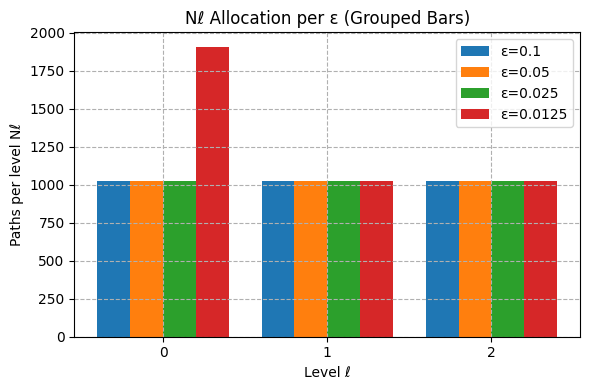

In [38]:
levels = np.arange(max(len(rec["N_per_level"]) for rec in records))
bar_width = 0.8 / len(records)
fig, ax = plt.subplots(figsize=(6, 4))
for i, rec in enumerate(records):
    Nl = rec["N_per_level"]
    ax.bar(levels + i*bar_width, Nl, width=bar_width, label=f"ε={rec['epsilon']}")
ax.set_xticks(levels + bar_width*(len(records)-1)/2)
ax.set_xticklabels(levels)
ax.set_xlabel("Level ℓ")
ax.set_ylabel("Paths per level Nℓ")
ax.set_title("Nℓ Allocation per ε (Grouped Bars)")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


In [36]:
# Inspect Yₗ for levels 0 and 1 to compare payoff variance vs. increment variance
N_test = 100_000

for l_test in [0, 1, 2]:
    # simulate N_test coupled samples at level l_test
    sums, cost = mlmc._f(l_test, N_test)
    sumY, sumY2 = sums

    # empirical mean and variance of Yₗ
    meanY = sumY  / N_test
    varY  = sumY2 / N_test - meanY**2

    print(f"Level {l_test}: mean(Y_{l_test}) = {meanY:.3e}, var(Y_{l_test}) = {varY:.3e}")


Level 0: mean(Y_0) = 5.324e-01, var(Y_0) = 2.230e-01
Level 1: mean(Y_1) = 0.000e+00, var(Y_1) = 0.000e+00
Level 2: mean(Y_2) = 0.000e+00, var(Y_2) = 0.000e+00
